# Configurations

In [12]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import matplotlib as mpl

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

rc = {'text.color': 'black',
      'axes.labelcolor': 'black',
      'xtick.color': 'black',
      'ytick.color': 'black',
      'axes.edgecolor': 'black',
      'font.family': 'Helvetica',
      'axes.linewidth': 1,
      'axes.labelpad': 6,
      'xtick.major.pad': 10,
      'xtick.major.width': 1,
      'ytick.major.width': 1,
      'lines.linewidth': 1,
      'font.size': 12,
      'axes.titlesize': 12,
      'axes.labelsize': 12,
      'xtick.labelsize': 12,
      'ytick.labelsize': 12,
      'legend.title_fontsize': 11,
      'legend.fontsize': 11,
      'figure.titlesize': 12,
      'figure.dpi': 72 * 3,
      'savefig.dpi': 72 * 4
      }
mpl.rcParams.update(rc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir=os.path.join(output_dir, 'figures', 'sfp_model', 'results_1D')
precision_dir='/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
roi_list=['V1','V2','V3']
lr = 0.005
max_epoch = 8000

In [14]:
ww = ww.groupby(['sub','voxel','class_idx','vroinames']).mean().reset_index()

ww.class_idx.unique()


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [15]:
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
voxels='pRFcenter'

# eccentricity bin information
e1, e2=0.5, 4
enum=7
enum_range=range(7) if enum==7 else range(3) 
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)
broderick_bin_list, broderick_bin_labels = tuning.get_bin_labels(1, 12, enum=11)


a = [3,2,0]
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in a]
roi_pal.insert(0, (0.5,0.5,0.5))


# Load the data and model parameters

## NSD data: data, fitting results, precision

In [16]:
# NSD data
f, m = [], []
for subj, roi in itertools.product(nsd_subj_list, roi_list):
    file_name = f'e1-{e1}_e2-{e2}_nbin-{enum}_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'binned', file_name))
nsd_subj_df = utils.load_dataframes(f)
nsd_subj_df = nsd_subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

args = ['sub', 'class', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
# NSD fitting results
pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(nsd_subj_list, roi_list, enum_range, ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
nsd_tuning_df = tuning.load_all_models(pt_file_list, *args)

# NSD precision data
file_list = []
for subj, roi in itertools.product(nsd_subj_list, ['V1','V2','V3']):
    f = os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision', 
                     f'precision-v_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

### Merge all the dataframes and fit a line to the weighted mean

In [17]:

nsd_tuning_with_precision_df = nsd_tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
nsd_tuning_with_precision_df['pp'] = 1/ nsd_tuning_with_precision_df['mode']
nsd_fit_df = vis1D.fit_line_to_weighted_mean(nsd_tuning_with_precision_df, 'pp', 'precision', groupby=['vroinames'])

## Broderick data: data, fitting results, precision

In [18]:
# Broderick data
f, m = [], []
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    file_name = f'tfunc-uncorrected_e1-1_e2-12_nbin-11_dset-broderick_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'before_w_a_correction', 'dataframes', 'broderick', 'binned', file_name))
broderick_subj_df = utils.load_dataframes(f)
broderick_subj_df = broderick_subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

# Broderick fitting results
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
pt_file_list = []
## drop the last bin data to avoid edge effects
for subj, roi, curbin, stim_class in itertools.product(broderick_subj_list, ['V1'], range(10), ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'tfunc-uncorrected_model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-1_e2-12_nbin-11_curbin-{curbin}_dset-broderick_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'before_w_a_correction', 'sfp_model', 'results_1D', 'broderick', file_name))
broderick_tuning_df = tuning.load_all_models(pt_file_list, *args)

# precision
file_list = []
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    f = os.path.join(output_dir, 'before_w_a_correction', 'dataframes', 'broderick', 'precision', 
                     f'precision-v_dset-broderick_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

In [19]:
broderick_tuning_with_precision_df = broderick_tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
broderick_tuning_with_precision_df['pp'] = 1/ broderick_tuning_with_precision_df['mode']
broderick_fit_df = vis1D.fit_line_to_weighted_mean(broderick_tuning_with_precision_df, 'pp', 'precision', groupby=['vroinames'])

## Merge the two datasets

In [20]:
# categorize based on dset and goal
broderick_tuning_with_precision_df['dset_type'] = 'Broderick et al. V1'
broderick_fit_df['dset_type'] = 'Broderick et al. V1'
broderick_tuning_with_precision_df['goal'] = 'Replication'
broderick_fit_df['goal'] = 'Replication'

nsd_tuning_with_precision_df['dset_type'] = nsd_tuning_with_precision_df['vroinames'].apply(lambda x: f'NSD {x}')
nsd_fit_df['dset_type'] = nsd_fit_df['vroinames'].apply(lambda x: f'NSD {x}')
nsd_tuning_with_precision_df['goal'] = nsd_tuning_with_precision_df['vroinames'].apply(lambda x: 'Replication' if x == 'V1' else 'Extension')
nsd_fit_df['goal'] = nsd_fit_df['vroinames'].apply(lambda x: 'Replication' if x == 'V1' else 'Extension')

tmp = nsd_tuning_with_precision_df.query('vroinames == "V1"')
tmp['goal'] = 'Extension'
nsd_tuning_with_precision_df = pd.concat((tmp, nsd_tuning_with_precision_df), axis=0)

tmp = nsd_fit_df.query('vroinames == "V1"')
tmp['goal'] = 'Extension'
nsd_fit_df = pd.concat((tmp, nsd_fit_df), axis=0)

tuning_with_precision_df = pd.concat((broderick_tuning_with_precision_df, 
                                      nsd_tuning_with_precision_df), axis=0)
fit_df = pd.concat((broderick_fit_df, nsd_fit_df), axis=0)

# Plot tuning curves for NSD V1, V2, V3

(<Figure size 1512x540 with 3 Axes>,
 array([<AxesSubplot:title={'center':'NSD V1'}>,
        <AxesSubplot:title={'center':'NSD V2'}>,
        <AxesSubplot:title={'center':'NSD V3'}>], dtype=object))

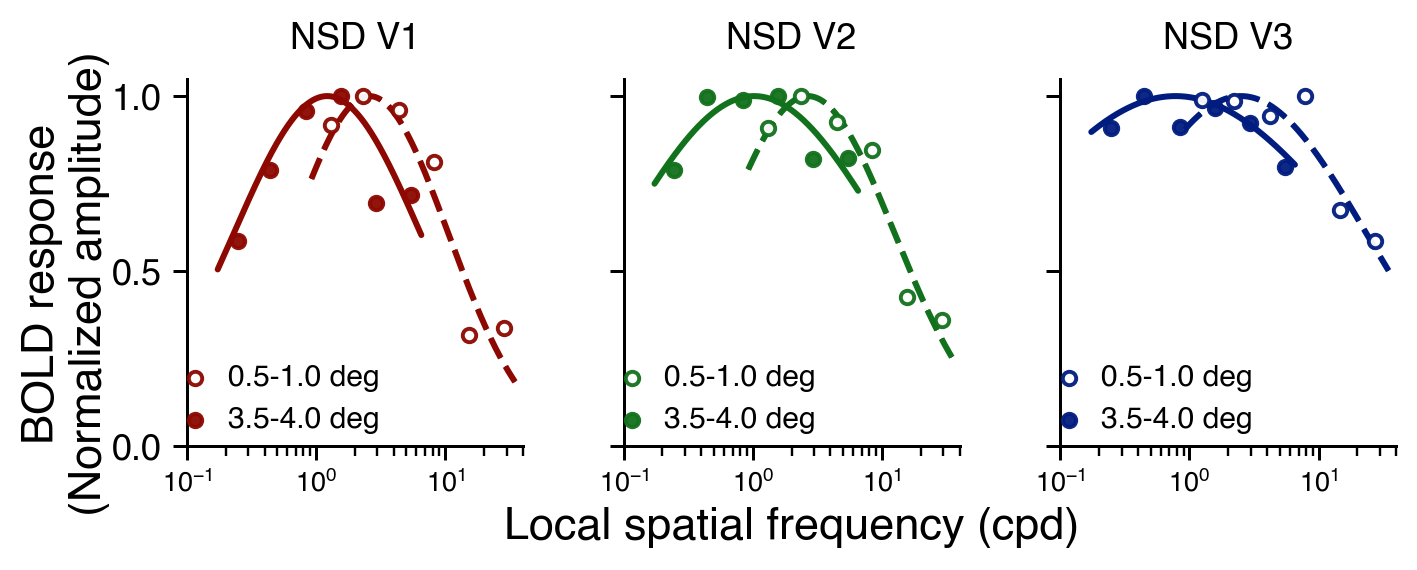

In [26]:
bins_to_plot = [bin_labels[k] for k in [0,6]]
vis1D.plot_tuning_curves_NSD(nsd_subj_df, nsd_tuning_df, subj='subj06', bins_to_plot=bins_to_plot, pal=roi_pal[1:])

# Plot preferred period as function of eccentricity

In [22]:
# Extend NSD V1 line up to 10 deg
ecc_max = fit_df.query('dset_type == "Broderick et al. V1"').ecc.max()
tmp_fit_df = fit_df.query('dset_type == "NSD V1" & goal == "Replication" & ecc == 0')
coeff = tmp_fit_df['coefficient'].iloc[0].tolist()
tmp_fit_df['ecc'] = ecc_max
tmp_fit_df['fitted'] = coeff[0] * ecc_max + coeff[1]
fit_df = pd.concat((fit_df, tmp_fit_df), axis=0)

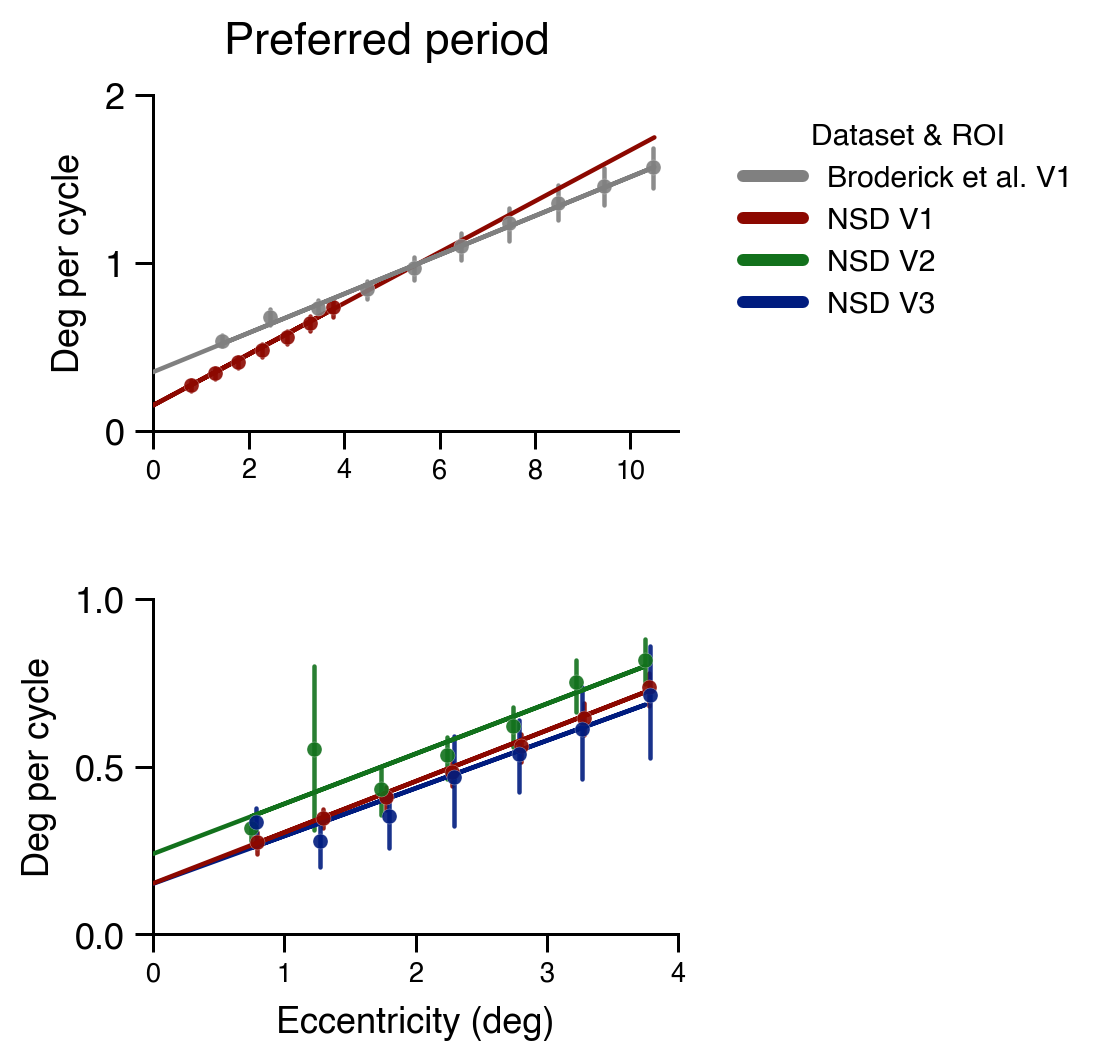

In [23]:
g = vis1D.plot_preferred_period(tuning_with_precision_df, fit_df=fit_df, 
                                row='goal', row_order=['Replication','Extension'], 
                                preferred_period='pp', precision='precision', hue='dset_type', 
                                hue_order=['Broderick et al. V1', 'NSD V1','NSD V2','NSD V3'], lgd_title='Dataset & ROI',
                                pal=roi_pal,
                                suptitle='Preferred period',
                                save_path=os.path.join(fig_dir, 'all', 'rep-ext-pperiod_class-avg_lr-0.005_eph-8000_e1-0.5_e2-4_nbin-7_vs-pRFcenter.svg'))

# Plot Bandwidth as function of eccentricity

In [24]:
tuning_with_precision_df['fwhm'] = tuning_with_precision_df['sigma']*2.335
fit_bandwidth_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df, 'fwhm', 'precision', groupby=['dset_type','goal'])

tmp_fit_df = fit_bandwidth_df.query('dset_type == "NSD V1" & goal == "Replication" & ecc == 0')
coeff = tmp_fit_df['coefficient'].iloc[0].tolist()
tmp_fit_df['ecc'] = ecc_max
tmp_fit_df['fitted'] = coeff[0] * ecc_max + coeff[1]
fit_bandwidth_df = pd.concat((fit_bandwidth_df, tmp_fit_df), axis=0)


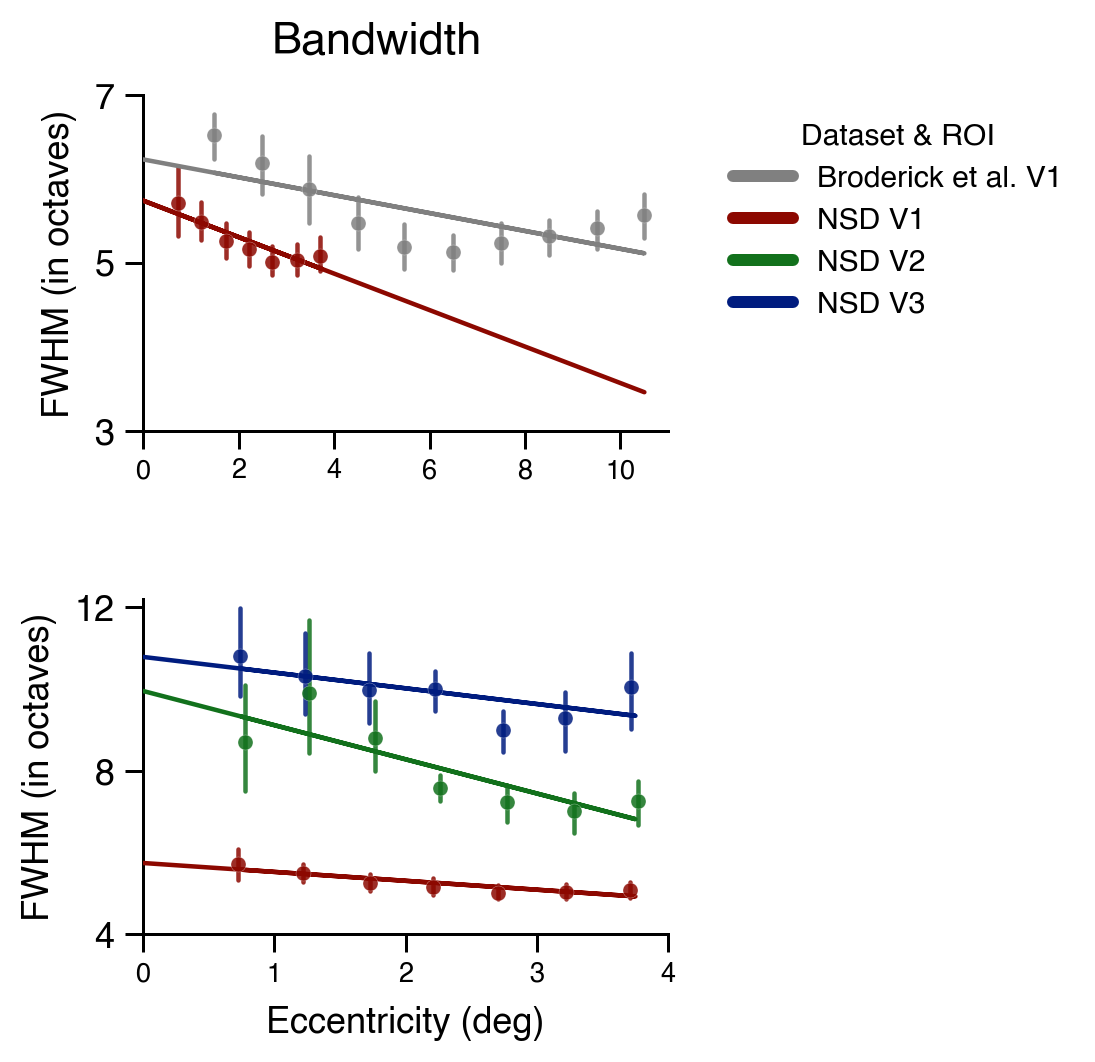

In [25]:
vis1D.plot_bandwidth_in_octaves(df=tuning_with_precision_df, fit_df=fit_bandwidth_df,
                               bandwidth='fwhm', precision='precision', 
                               row='goal', row_order=['Replication','Extension'], 
                               hue='dset_type', 
                                hue_order=['Broderick et al. V1', 'NSD V1','NSD V2','NSD V3'],
                                lgd_title='Dataset & ROI',
                                pal=roi_pal,
                                suptitle='Bandwidth',
                               save_path=os.path.join(fig_dir, 'all', 'rep-ext-bandwidth_class-avg_lr-0.005_eph-8000_e1-0.5_e2-4_nbin-7_vs-pRFcenter.svg'))